In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score as r2
import warnings 

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

plt.figure(figsize=(18, 18))

<Figure size 1296x1296 with 0 Axes>

<Figure size 1296x1296 with 0 Axes>

In [2]:
DATA_TRAINS = 'train.csv'
DATA_TEST = 'test.csv'

In [3]:
trains = pd.read_csv(DATA_TRAINS)
trains_w = trains.copy()

In [4]:
trains.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
trains.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
tests = pd.read_csv(DATA_TEST)

In [7]:
tests.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
trains['Id'] = trains['Id'].astype(str)
trains['DistrictId'] = trains['DistrictId'].astype(str)

## 1. EDA

Делаем EDA для:

 * Исправления выбросов

 * Заполнения

 * Идей для генерации новых фич

### **Целевая переменнная**

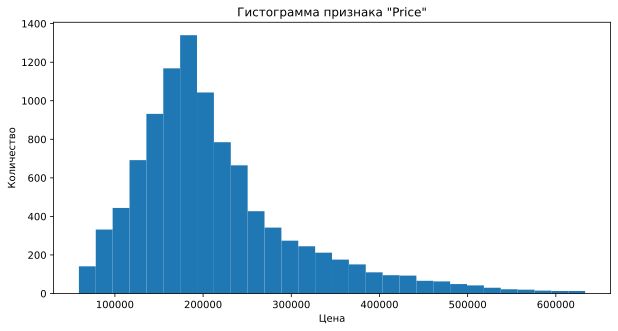

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(trains['Price'], bins=30)
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.title('Гистограмма признака "Price"')
plt.show()

Распределение целевого впризнака **"Price"** выглядит правдоподобным

### **Количественные переменнные**

In [10]:
trains.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### **Номинативные переменные**

In [11]:
for column_name, column_values in trains.select_dtypes(include='object').iteritems():
    print()
    print("-----------------")
    print()
    print(column_name)
    print()
    print(column_values.value_counts())


-----------------

Id

9815     1
13627    1
1235     1
5385     1
962      1
        ..
2377     1
12577    1
8153     1
2915     1
3574     1
Name: Id, Length: 10000, dtype: int64

-----------------

DistrictId

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
207      1
199      1
209      1
117      1
Name: DistrictId, Length: 205, dtype: int64

-----------------

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64

-----------------

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64

-----------------

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64


## 2. Обработка выбросов

1. Выкинуть данные

2. Заменять выбросы разными данными (медианы, средние значения и т. д.)

3. Делать или не делать дополнительную фичу

4. Ничего не делать

### Экстримально маленькие и экстримально большие значения  в Square

In [12]:
rooms_median = trains[trains['Rooms'] < 6].groupby('Rooms').agg({'Square': 'median'})
square_rooms_median_list = rooms_median.values.T[0].tolist()


condition_extr_values_sqaure = (trains['Square'] < trains['Square'].quantile(0.0025)) | (trains['Square'] > trains['Square'].quantile(0.9975))

trains.loc[condition_extr_values_sqaure, 'Square'] = square_rooms_median_list[int(trains[condition_extr_values_sqaure]['Rooms'].values[0]) - 1]

### **Rooms = 0**

Есть квартиры с признаком **Rooms = 0**, заменим значения 0 на 1:

In [13]:
trains.loc[trains['Rooms'] == 0, 'Rooms'] = 1

### **HouseYear > 2020**

In [14]:
trains.loc[trains['HouseYear'] > 2020, 'HouseYear'] = 2020

### HouseFloor = 0

In [15]:
mode_housefloor = trains.loc[trains['HouseFloor'] != 0].groupby('HouseYear').agg(
    housefloor_mode=('HouseFloor', lambda x: x.value_counts().index[0]),
)

trains = pd.merge(trains, mode_housefloor, on='HouseYear')

trains.loc[(trains['HouseFloor'] == 0), 'HouseFloor'] = trains['housefloor_mode']
trains.drop('housefloor_mode', axis=1, inplace=True)

### Floor = 0

In [16]:
# заполним рандомно значениями из интервала от 1 до'HouseFloor'
np.random.seed(42)

trains.loc[trains['Floor'] == 0, 'Floor'] = np.random.randint(1, trains[trains['Floor'] == 0]['HouseFloor'] + 1)

### Большие значения Rooms

In [17]:
rooms_median = trains[trains['Rooms'] < 6].groupby('Rooms').agg({'Square': 'median'})
square_rooms_median_list = rooms_median.values.T[0].tolist()


def get_correct_rooms(square):    
    room_square = min([(square_rooms_median_list.index(m) + 1, np.abs(m - square.values[0])) for m in square_rooms_median_list], key=lambda x: x[1])
    return room_square[1]


trains.loc[trains['Rooms'] > 5, 'Rooms'] = get_correct_rooms(trains[trains['Rooms'] > 5]['Square'])

In [18]:
# trains_s_200_r_5_condition = (trains['Square'] > 200) & (trains['Rooms'] < 5)

# trains.loc[trains_s_200_r_5_condition, ]

In [19]:
trains.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.887414,56.053765,37.199645,6.273300,8.526700,13.066700,1984.872400,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.811466,18.079547,86.241209,28.560917,5.241148,6.476561,18.416347,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,22.072457,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.826100,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.665690,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.822192,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,151.150660,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### **Healthcare_1** пропущенные данные

In [20]:
# получим средние значения непустых значений признака "Healthcare_1" сгрупированых по "DistrictId"
healthcare_1_mean = trains[~trains['Healthcare_1'].isna()].\
                    groupby('DistrictId').agg(healthcare_1_mean=('Healthcare_1', 'mean'))

# объединим с тренировачным датасетом
trains = pd.merge(trains, healthcare_1_mean, on='DistrictId', how='left')

# заполним отсутствующие значения 
trains['Healthcare_1'].fillna(trains['healthcare_1_mean'], inplace=True)

# оставшиеся пустые значения заполним средим значением healthcare_1_mean
trains['Healthcare_1'].fillna(trains['healthcare_1_mean'].mean(), inplace=True)

# удалим признак "healthcare_1_mean"
trains.drop('healthcare_1_mean', axis=1, inplace=True)


### **LifeSquare** пропущенные данные

In [21]:
# сгруппирукем данные по полям 'HouseYear' и 'Rooms', чтоб получить средние значения 'Square' и 'LifeSquare'
lifesquare_mean = trains.loc[~trains['LifeSquare'].isna()].groupby(['HouseYear', 'Rooms']).agg(
    mean_s=('Square', 'mean'),
    mean_ls=('LifeSquare', 'mean'),
)

# объединим с тренировачным датасетом
trains = pd.merge(trains, lifesquare_mean, on=['HouseYear', 'Rooms'], how='left')

# заполняем отсутствующие значения LifeSquare по формуле Square * mean_ls / mean_s
trains['LifeSquare'].fillna(trains['Square'] * (trains['mean_ls'] / trains['mean_s']), inplace=True)

# все остальныы отсутствующие данные заполним Square - KitchenSquare + 4
trains.loc[trains['LifeSquare'].isna(), 'LifeSquare'] = trains['Square'] - (trains['KitchenSquare'] + 4)

# удаляем поля 'mean_s', 'mean_ls'
trains.drop(['mean_s', 'mean_ls'], axis=1, inplace=True)

### Существуют данные где **LifeSquare** > **Square** 

In [22]:
trains[trains['LifeSquare'] > trains['Square']]['Square'].count()

499

In [23]:
# Есть предположение, что при заполнении эти значения были перепутаны. Поменяем их местами:
trains.loc[trains['LifeSquare'] > trains['Square'], ['LifeSquare', 'Square']] = trains.loc[trains['LifeSquare'] > trains['Square'], ['Square', 'LifeSquare']].values

### Существуют данные где **KitchenSquare** > **LifeSquare** 

In [24]:
trains[trains['KitchenSquare'] > trains['LifeSquare']]['LifeSquare'].count()

24

In [25]:
# Есть предположение, что при заполнении эти значения были перепутаны. Поменяем их местами:
trains.loc[trains['KitchenSquare'] > trains['LifeSquare'], ['KitchenSquare', 'LifeSquare']] = trains.loc[trains['KitchenSquare'] > trains['LifeSquare'], ['LifeSquare', 'KitchenSquare']].values

### Существуют данные где **Floor** > **HouseFloor** 

In [26]:
trains[trains['Floor'] > trains['HouseFloor']]['HouseFloor'].count()

1578

In [27]:
# Есть предположение, что при заполнении эти значения были перепутаны. Поменяем их местами:
trains.loc[trains['Floor'] > trains['HouseFloor'], ['Floor', 'HouseFloor']] = trains.loc[trains['Floor'] > trains['HouseFloor'], ['HouseFloor', 'Floor']].values

### Существуют данные где **KitchenSquare** == 0 и **KitchenSquare** == 1

In [28]:
# сгруппирукем данные по полям 'HouseYear' и 'Rooms', чтоб получить средние значения 'Square' и 'KitchenSquare'
kitchensquare_mean = trains.loc[trains['KitchenSquare'] > 1].groupby(['HouseYear', 'Rooms']).agg(
     mean_s=('Square', 'mean'),
     mean_ks=('KitchenSquare', 'mean'),
)

# объединим с тренировачным датасетом
trains = pd.merge(trains, kitchensquare_mean, on=['HouseYear', 'Rooms'], how='left')


# заполняем отсутствующие значения KitchenSquare по формуле Square * mean_ks / mean_s
trains.loc[(trains['KitchenSquare'] <= 1), 'KitchenSquare'] = trains['Square'] * (trains['mean_ks'] / trains['mean_s'])

# удаялем ненужные признаки
trains.drop(['mean_s', 'mean_ks'], axis=1, inplace=True)

# все оставшиеся пропущенные значения заполним по формуле (Square / Rooms) / 2
trains['KitchenSquare'].fillna((trains['Square'] / trains['Rooms']) / 2, inplace=True)

In [29]:
class DataPreprocessing:
    """ Подготовка исходных данных """
    
    def __init__(self):
        """ Инициализация """
        self.mode_housefloor = None
        self.median_housefloor = None
        self.square_rooms_median_list = []
        self.healthcare_1_mean = None
        self.lifesquare_mean = None
        self.kitchensquare_mean = None
        # квантили признака Square q=0,25 и q=99,75
        self.square_q_min = None
        self.square_q_max = None
    
    def _correct_rooms(self, square):    
        room_square = min([(self.square_rooms_median_list.index(m) + 1, np.abs(m - square.values[0])) for m in self.square_rooms_median_list], key=lambda x: x[1])
        return room_square[1]

    def fit(self, X):
        """ Сохранение статистик """
        # получим моду этажности зданий сгрупированные по HouseYear
        self.mode_housefloor = X.loc[X['HouseFloor'] != 0].groupby('HouseYear').agg(
            housefloor_mode=('HouseFloor', lambda x: x.value_counts().index[0]),
        )
        
        self.median_housefloor = X['HouseFloor'].median()
        # получим список средних значений Square квартир скрупированных по Rooms
        rooms_median = X[X['Rooms'] < 6].groupby('Rooms').agg({'Square': 'median'})
        self.square_rooms_median_list = rooms_median.values.T[0].tolist()
        
        # получим средние значения непустых значений признака "Healthcare_1" сгрупированых по "DistrictId"
        self.healthcare_1_mean = X[~X['Healthcare_1'].isna()].\
                    groupby('DistrictId').agg(healthcare_1_mean=('Healthcare_1', 'mean'))
        
        # сгруппирукем данные по полям 'HouseYear' и 'Rooms', чтоб получить средние значения 'Square' и 'LifeSquare'
        self.lifesquare_mean = X.loc[~X['LifeSquare'].isna()].groupby(['HouseYear', 'Rooms']).agg(
            mean_s=('Square', 'mean'),
            mean_ls=('LifeSquare', 'mean'),
        )
        
        # сгруппирукем данные по полям 'HouseYear' и 'Rooms', чтоб получить средние значения 'Square' и 'KitchenSquare'
        self.kitchensquare_mean = X.loc[X['KitchenSquare'] > 1].groupby(['HouseYear', 'Rooms']).agg(
             mean_s=('Square', 'mean'),
             mean_ks=('KitchenSquare', 'mean'),
        )
        
        # condition_lifesquare_calc = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        # self.lifesquare_calc = X.loc[condition_lifesquare_calc, 'Square'] - (X.loc[condition_lifesquare_calc, 'KitchenSquare'] + 3)
        # квантили признака Square q=0,25 и q=99,75
        self.square_q_min = X['Square'].quantile(0.0025)
        self.square_q_max = X['Square'].quantile(0.9975)
        
        self.lifesquare_median = X['LifeSquare'].median()
    
    def transform(self, X):
        """ Трансформация данных """
        X = X.copy()
        
        # Есть квартиры с признаком **Rooms = 0**, заменим значения 0 на 1:
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        # зменим HouseYear > 2020 на 2020
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        X = pd.merge(X, self.mode_housefloor, on='HouseYear', how='left')

        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = X['housefloor_mode']
        
        X['HouseFloor'].fillna(self.median_housefloor, inplace=True)
        
        X.drop('housefloor_mode', axis=1, inplace=True)
        
        # заполним рандомно значениями из интервала от 1 до 'HouseFloor'
        X.loc[X['Floor'] == 0, 'Floor'] = np.random.randint(1, X[X['Floor'] == 0]['HouseFloor'] + 1)
        
        X.loc[X['Rooms'] > 5, 'Rooms'] = self._correct_rooms(X[X['Rooms'] > 5]['Square'])
        
        # объединим с тренировачным датасетом
        X = pd.merge(X, self.healthcare_1_mean, on='DistrictId', how='left')

        # заполним отсутствующие значения 
        X['Healthcare_1'].fillna(X['healthcare_1_mean'], inplace=True)

        # оставшиеся пустые значения заполним средим значением healthcare_1_mean
        X['Healthcare_1'].fillna(X['healthcare_1_mean'].mean(), inplace=True)

        # удалим признак "healthcare_1_mean"
        X.drop('healthcare_1_mean', axis=1, inplace=True)
        
        # объединим с тренировачным датасетом
        X = pd.merge(X, self.lifesquare_mean, on=['HouseYear', 'Rooms'], how='left')

        # заполняем отсутствующие значения LifeSquare по формуле Square * median_ls / median_s
        X['LifeSquare'].fillna(X['Square'] * (X['mean_ls'] / X['mean_s']), inplace=True)
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X['Square'] - (X['KitchenSquare'] + 4)
        # X['LifeSquare'].fillna(self.lifesquare_calc, inplace=True)
        # X['LifeSquare'].fillna(self.lifesquare_median, inplace=True)
        # все остальныы отсутствующие данные заполним Square - KitchenSquare + 4
    
        # удаляем поля 'median_s', 'median_ls'
        X.drop(['mean_ls', 'mean_s'], axis=1, inplace=True)
        
        # Есть предположение, что при заполнении эти значения были перепутаны. Поменяем их местами:
        # X.loc[X['LifeSquare'] > X['Square'], ['LifeSquare', 'Square']] = X.loc[X['LifeSquare'] > X['Square'], ['Square', 'LifeSquare']].values

        # Есть предположение, что при заполнении эти значения были перепутаны. Поменяем их местами:
        # X.loc[X['KitchenSquare'] > X['LifeSquare'], ['KitchenSquare', 'LifeSquare']] = X.loc[X['KitchenSquare'] > X['LifeSquare'], ['LifeSquare', 'KitchenSquare']].values
        
        # Есть предположение, что при заполнении эти значения были перепутаны. Поменяем их местами:
        X.loc[X['Floor'] > X['HouseFloor'], ['Floor', 'HouseFloor']] = X.loc[X['Floor'] > X['HouseFloor'], ['HouseFloor', 'Floor']].values
        
        # объединим с тренировачным датасетом
        X = pd.merge(X, self.kitchensquare_mean, on=['HouseYear', 'Rooms'], how='left')

        # заполняем отсутствующие значения KitchenSquare по формуле Square * mean_ks / mean_s
        X.loc[(X['KitchenSquare'] <= 1), 'KitchenSquare'] = X['Square'] * (X['mean_ks'] / X['mean_s'])

        # удаялем ненужные признаки
        X.drop(['mean_s', 'mean_ks'], axis=1, inplace=True)

        # все оставшиеся пропущенные значения заполним по формуле (Square / Rooms) / 2
        X['KitchenSquare'].fillna((X['Square'] / X['Rooms']) / 2, inplace=True)
        
        # выбросы в признаке Square заменим медианой
        # X.loc[(trains['Square'] < self.square_q_min) | (X['Square'] > self.square_q_max), 'Square'] =  X['Square'].median()
        
        # X.loc[X['KitchenSquare'] > X['KitchenSquare'].quantile(0.975), 'KitchenSquare'] =  X['KitchenSquare'].median()
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] =  3
        
        #X.loc[X['KitchenSquare'] > self.square_q_max), 'KitchenSquare'] =  X['KitchenSquare'].median()
        
        # X.loc[(trains['LifeSquare'] < self.square_q_min) | (X['LifeSquare'] > self.square_q_max), 'LifeSquare'] =  X['LifeSquare'].median()
        
        return X

In [30]:
class FeatureGenerator:
    """ Генератор признаков """
    
    def __init__(self):
        """ Инициализация """
        self.column_year_range = 'YearRange'
        self.column_price_square_meter_district = 'PriceDistirictRooms'
        
        self.categorial_replace = {}
        self.range_years = []
        self.price_median_by_district = None
    
    def _range_year_index(self, house_year):    
        for idx, range_year in enumerate(self.range_years, 1):
            if house_year > range_year[0] and house_year <= range_year[1]:
                return idx
            
    def floor_to_cat(self, X):

        X['floor_cat'] = 0

        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5

        return X

    def year_to_cat(self, X):

        X['year_cat'] = 0

        X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

        return X
            
    def fit(self, X, y=None):
        """ Сохранение статистик """
        X = X.copy()
        
        self.categorial_replace = {
            'Shops_2': {'A': 0, 'B': 1},
            'Ecology_3': {'A': 0, 'B': 1},
            'Ecology_2': {'A': 0, 'B': 1},
        }
        
        self.range_years = [
            (0, 1970),
            (1970, 1980),
            (1980, 1990),
            (1990, 2000),
            (2000, 2010),
            (2010, 2021),
        ]
        
        
        X['Price'] = y.values
        self.price_median_by_district = X.groupby(['DistrictId', 'Rooms']).\
                                      agg(price_median_by_district=('Price', 'median')).\
                                      rename(columns={'price_median_by_district': self.column_price_square_meter_district})
        self.price_median = X['Price'].median()
        
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        self.med_price_by_floor_year = X.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()

    def transform(self, X, y=None):
        """ Трансформация данных """
        X = X.copy()
        
        # Healthcare_1
        # if 'Healthcare_1' in X.columns:
        #    X.drop('Healthcare_1', axis=1, inplace=True)
        
        # переведем категриальные признаки в числовой 
        X.replace(self.categorial_replace, inplace=True)
        
        # создим колонку HouseYear с значениями 1 - 6 характеризующее старость дома
        # X[self.column_year_range] = X['HouseYear'].apply(self._range_year_index)
        if self.price_median_by_district is not None:
            # создадим признак средняя стоимость по квадратного метра по каждом району PriceSquareMeterDistirict
            X = pd.merge(X, self.price_median_by_district, on=['DistrictId', 'Rooms'], how='left')
            X[self.column_price_square_meter_district].fillna(self.price_median, inplace=True)
            
        X.drop(['DistrictId', 'Id'], axis=1, inplace=True)
        
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        # X = pd.merge(X, self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X


In [31]:
trains = trains[(trains['Square'] > trains['Square'].quantile(0.0025)) & (trains['Square'] < trains['Square'].quantile(0.9975))]
trains.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000,9950.000000
mean,1.887753,56.217645,38.161630,8.893674,7.942613,13.671256,1984.851558,0.118875,24.676080,5349.849045,7.975779,1047.073577,1.317085,4.223116,214232.031254
std,0.809936,18.141637,32.554637,3.888322,5.207275,6.003146,18.396646,0.119125,17.541184,4007.772406,23.663871,914.004778,1.494070,4.790900,92713.784802
min,1.000000,27.245731,0.370619,1.626502,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.944958,25.077060,7.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,240.000000,0.000000,1.000000,154156.146500
50%,2.000000,52.798628,33.862401,9.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1048.620708,1.000000,3.000000,192342.953556
75%,2.000000,65.933070,47.093835,10.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1322.000000,2.000000,6.000000,249347.803240
max,5.000000,153.685835,2014.000000,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


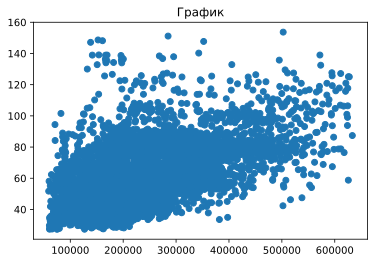

In [32]:
plt.scatter(trains['Price'], trains['Square'])
plt.title('График')
plt.show()

In [33]:
scaler = MinMaxScaler()

In [34]:
# trains_scaled = pd.DataFrame(scaler.fit_transform(trains), columns=trains.columns)
# trains_scaled

In [35]:
y = trains_w[['Price']]
X = trains_w.drop('Price', axis=1)
X[X['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_valid.shape, tests.shape

((6700, 19), (3300, 19), (5000, 19))

In [37]:
dp = DataPreprocessing()
dp.fit(X_train)

X_train = dp.transform(X_train)
X_valid = dp.transform(X_valid)
tests = dp.transform(tests)
X_train.shape, X_valid.shape, tests.shape

((6700, 19), (3300, 19), (5000, 19))

In [38]:
fg = FeatureGenerator()
fg.fit(X_train, y_train)

X_train = fg.transform(X_train)
X_valid = fg.transform(X_valid)
tests = fg.transform(tests)

In [39]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [5, 10, 15, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [300, 500]}

In [40]:
rfr =  RandomForestRegressor(criterion='mse')

In [41]:
rf_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs = -1,
)

In [42]:
# rf_random.fit(X_train, y_train)

In [43]:
# y_pred_rf = rf_random.predict(X_valid)

In [44]:
# r2(y_valid, y_pred_rf)

In [45]:
random_grid = {
 'max_depth': [15, 20, 25],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [400, 500, 600]
}

In [46]:
gbr = GradientBoostingRegressor(criterion='mse')

In [47]:
gbr_random = RandomizedSearchCV(
    estimator=rfr, 
    param_distributions=random_grid, 
    n_iter=10, 
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs = -1,
)

In [48]:
gbr_random.fit(X_train, y_train)
y_pred_clf = gbr_random.predict(X_valid)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [49]:
r2(y_valid, y_pred_clf)

0.6813191625736068

In [50]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [51]:
tests_predict = gbr_random.predict(tests)

In [52]:
submit['Price'] = tests_predict

In [53]:
submit

,Id,Price
0,4567,155308.749421
1,5925,124288.958681
2,960,139767.286080
3,3848,135299.192219
4,746,185267.830690
...,...,...
4995,10379,181685.633212
4996,16138,417050.164453
4997,3912,144070.413520
4998,5722,181605.060535


In [54]:
submit.to_csv('price_prediction.csv', index=False)